In [23]:
# Import the require libraries and images

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template
from PIL import Image

ImagenTotal = np.asarray(Image.open('/home/nvaldebenito/Documents/40_trabajo_jsalinas/output/tif/NDVI.tif'))





In [ ]:
plot_spatial_array(ImagenTotal,
                chm_ext,
                (1,250),
                title='Region de estudio',
                cmap_title='NDVI BANDA 2',
                colormap='BuGn')

In [24]:
import copy
chm_reclass = copy.copy(chm_array)
chm_reclass[np.where(chm_array==0)] = 1 # CHM = 0 : Class 1
chm_reclass[np.where((chm_array>0) & (chm_array<=20))] = 2 # 0m < CHM <= 10m - Class 2
chm_reclass[np.where((chm_array>20) & (chm_array<=60))] = 3 # 10m < CHM <= 20m - Class 3
chm_reclass[np.where((chm_array>60) & (chm_array<=230))] = 4 # 20m < CHM <= 30m - Class 4
chm_reclass[np.where(chm_array>230)] = 5 # CHM > 30m - Class 5

NameError: name 'chm_array' is not defined

In [ ]:
import matplotlib.colors as colors
print(type(chm_reclass))
plt.figure(); 
cmapCHM = colors.ListedColormap(['lightblue','yellow','orange','green','red'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='lightblue', label='CHM = 0m')
class2_box = mpatches.Patch(color='yellow', label='0m < CHM <= 50m')
class3_box = mpatches.Patch(color='orange', label='50m < CHM <= 100m')
class4_box = mpatches.Patch(color='green', label='100m < CHM <= 230m')
class5_box = mpatches.Patch(color='red', label='CHM > 230m')

ax.legend(handles=[class1_box,class2_box,class3_box,class4_box,class5_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

<IPython.core.display.Javascript object>


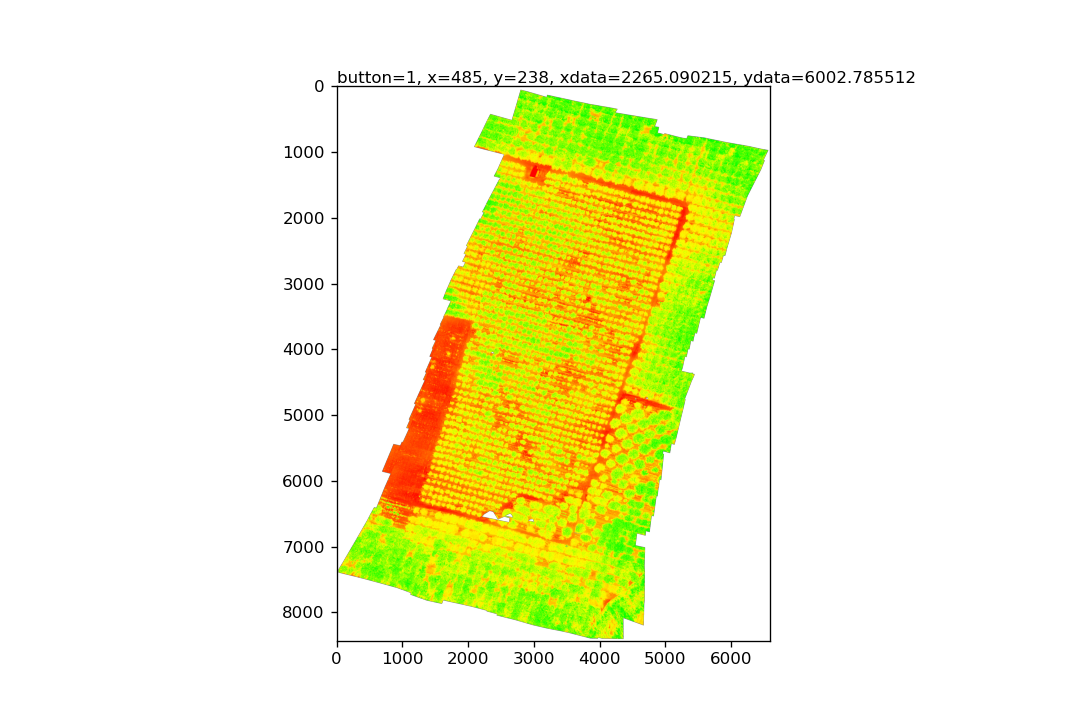

In [20]:
# Interactive selection of points

#define empty cells 
puntosinteres = []

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.imshow(ImagenTotal, cmap=plt.cm.gray)
text=ax.text(0,0, "", va="bottom", ha="left")


#interactive function that stores points clicked on the image
def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    puntosinteres.append([event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [21]:

# amount of points clicked
len(puntosinteres)


6

<IPython.core.display.Javascript object>


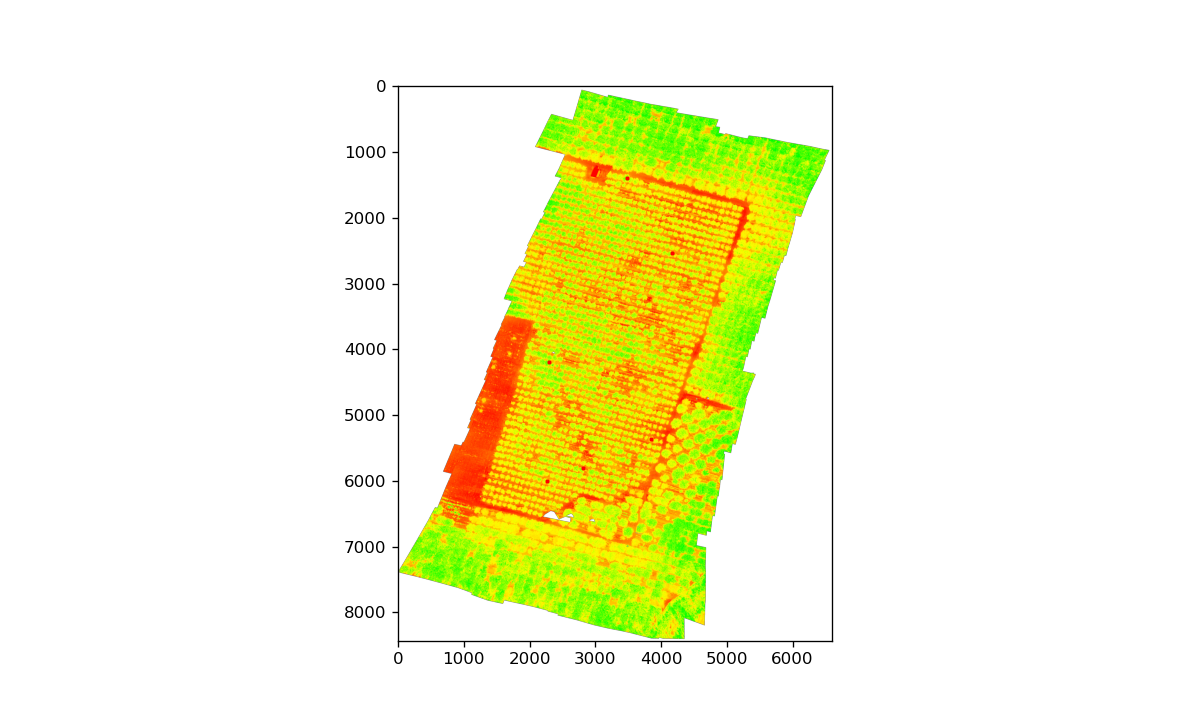

<IPython.core.display.Javascript object>


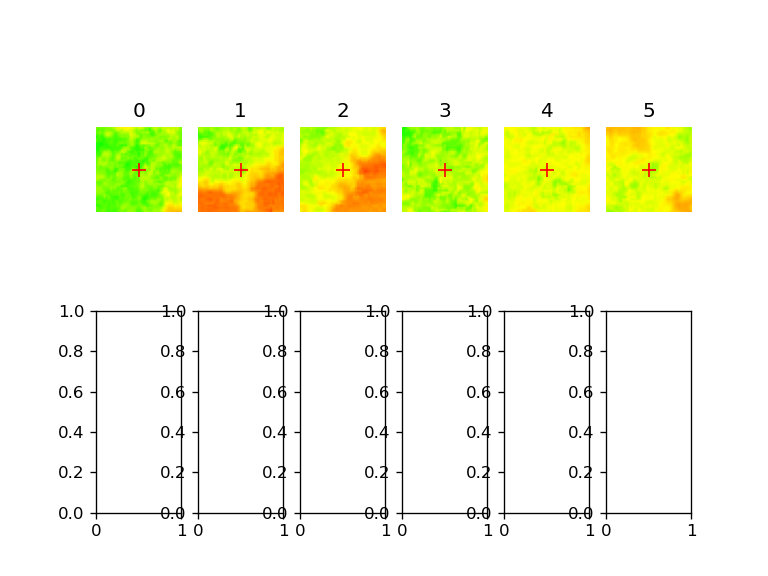

In [22]:

#plot points over the image and select more if you want
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(ImagenTotal, cmap=plt.cm.gray)
ax.scatter([x[0] for x in puntosinteres],[y[1] for y in puntosinteres],c='red', marker='+', s=8)
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    puntosinteres.append([event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(len(puntosinteres)//6+1, 6)
i = 0
for item in puntosinteres:
    xinteres = int(item[0])
    yinteres = int(item[1])
    radio = 20
    ax[i//6,i-i//6*6].imshow(ImagenTotal)
    ax[i//6,i-i//6*6].plot(xinteres,yinteres,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[i//6,i-i//6*6].set_xlim(xinteres-radio,xinteres+radio)
    ax[i//6,i-i//6*6].set_ylim(yinteres-radio,yinteres+radio)
    ax[i//6,i-i//6*6].axis('off')
    ax[i//6,i-i//6*6].set_title(i)
    i+=1




In [ ]:
#in case you have a wrong point or a incomplete image please uncomment the following line with the point index to delete it
#del puntosinteres[13]
len(puntosinteres)

<IPython.core.display.Javascript object>


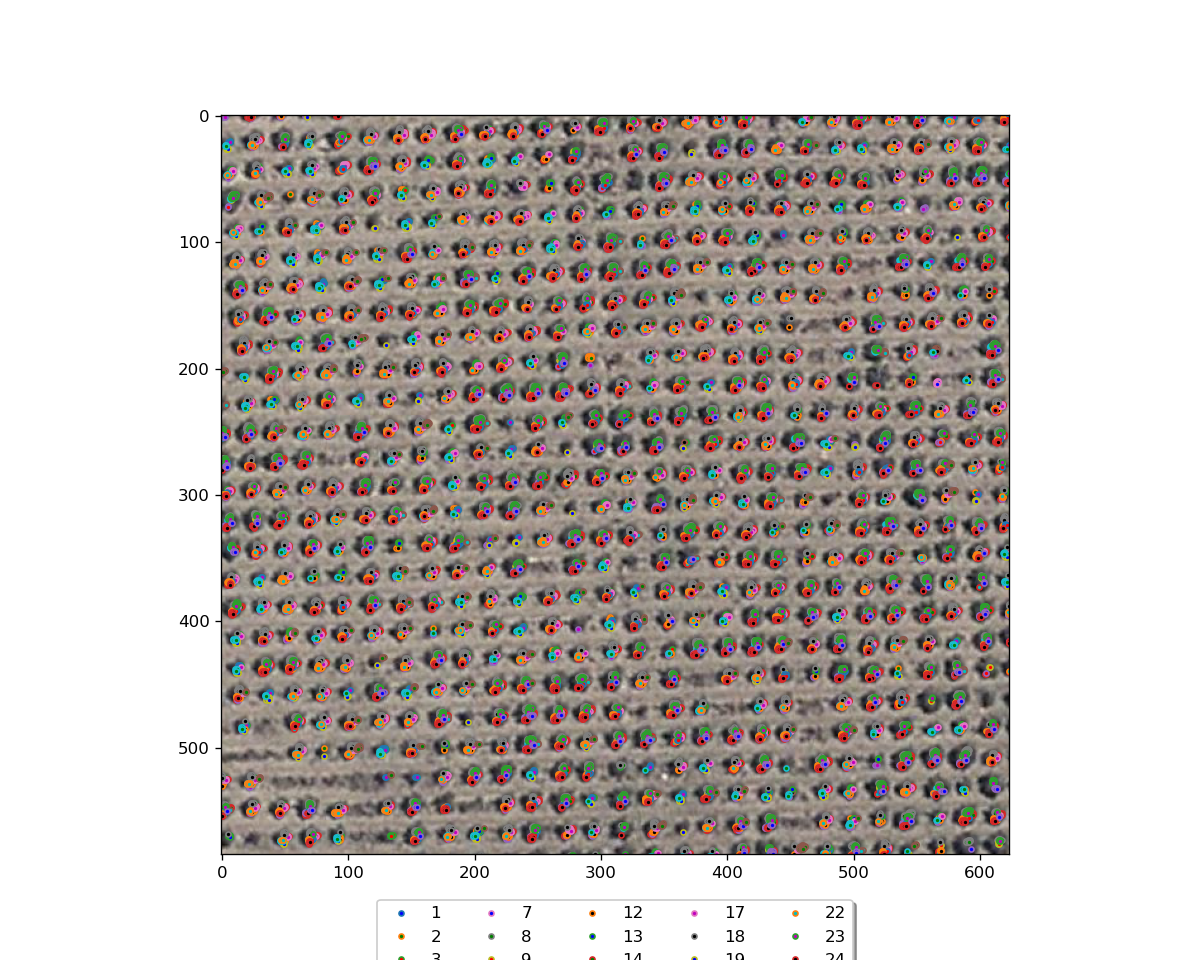

In [15]:
# Match the image to the template

listaresultados = []
for punto in puntosinteres:
    xinteres = int(punto[0])
    yinteres = int(punto[1])
    radio=10
    imagenband = ImagenTotal[:,:,0]
    templateband = ImagenTotal[yinteres-radio:yinteres+radio,xinteres-radio:xinteres+radio,0]
    result= match_template(imagenband, templateband)
    result = np.where(result>0.85)
    listaresultados.append(result)

# Plot interpreted points over the image

from itertools import cycle
cycol = cycle('bgrcmk')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

i = 1
for lista in listaresultados:
    ax.plot(lista[1],lista[0], '.', linewidth=0, markerfacecolor=next(cycol), label=i)
    i+=1
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.imshow(ImagenTotal[radio:-radio,radio:-radio,:])


26
[[  1 553]
 [  1 554]
 [  2 507]
 ...
 [580 458]
 [580 459]
 [580 460]]


<IPython.core.display.Javascript object>


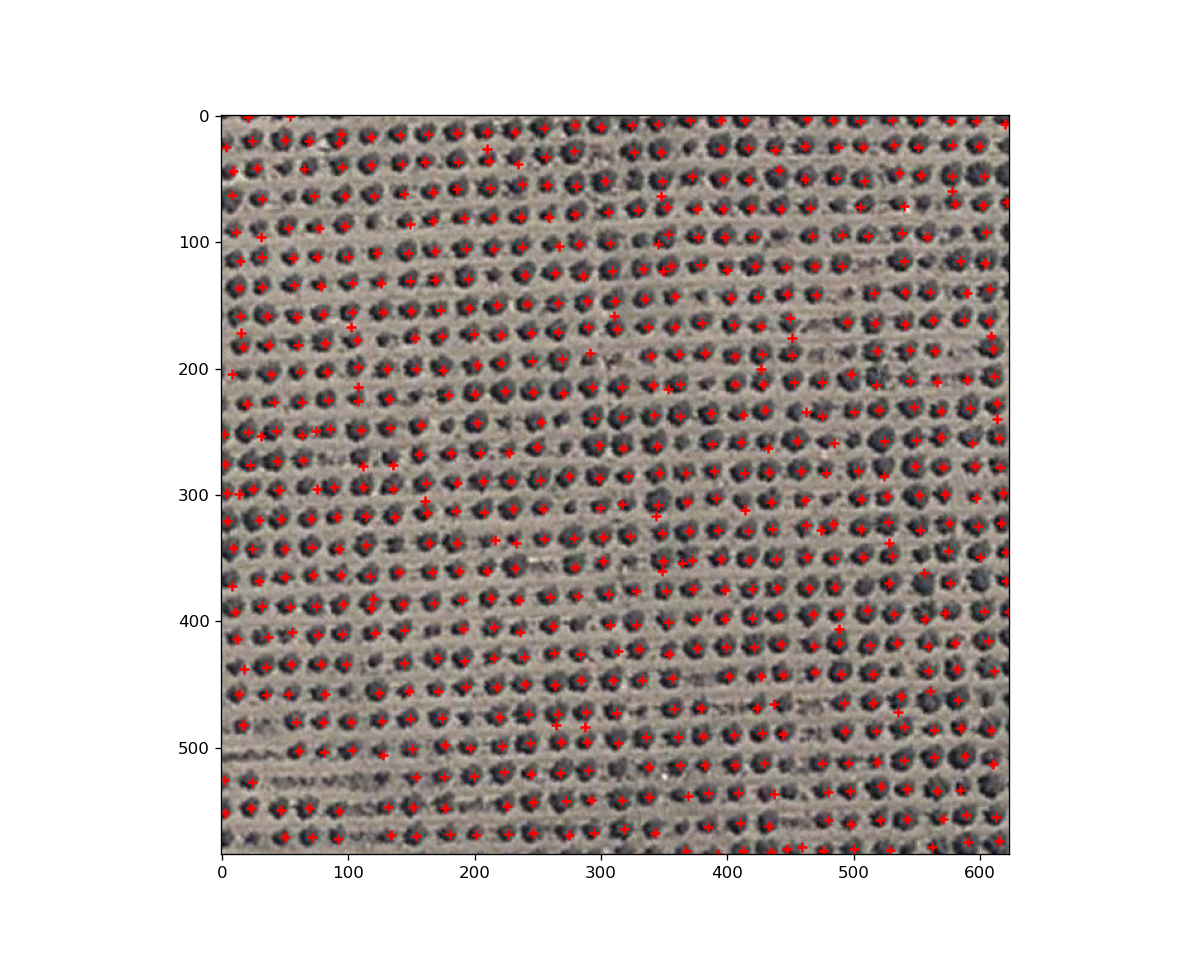

660

In [16]:
# Cluster analisys with Birch algorithm

datalist = [np.asarray(pares).T for pares in listaresultados]
print(len(datalist))
datalist = np.vstack(datalist)
print(datalist)

from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=10, compute_labels=True)
brc.fit(datalist)
puntosbirch = brc.subcluster_centers_
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(puntosbirch[:,[1]],puntosbirch[:,[0]], marker='+',color='red')
ax.imshow(ImagenTotal[radio:-radio,radio:-radio,:])

len(puntosbirch)

<IPython.core.display.Javascript object>


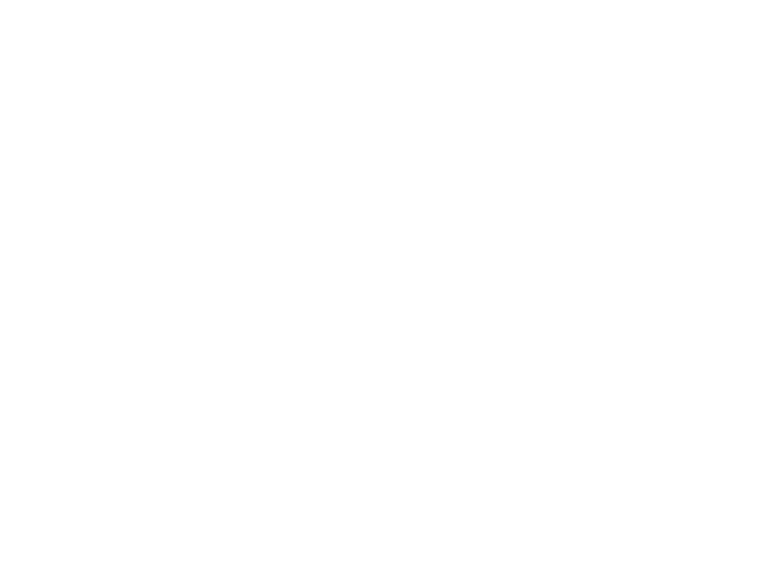

IndexError: index 2 is out of bounds for axis 1 with size 2

In [18]:
fig, ax = plt.subplots(len(puntosbirch)//6+1, 2)
i = 0
for item in puntosbirch:
    xinteres = int(item[0])
    yinteres = int(item[1])
    radio = 20
    ax[i//6,i-i//6*6].imshow(ImagenTotal)
    ax[i//6,i-i//6*6].plot(xinteres,yinteres,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[i//6,i-i//6*6].set_xlim(xinteres-radio,xinteres+radio)
    ax[i//6,i-i//6*6].set_ylim(yinteres-radio,yinteres+radio)
    ax[i//6,i-i//6*6].axis('off')
    ax[i//6,i-i//6*6].set_title(i)
    i+=1